<h1>Using the Planet OS API to Produce Weather Forecast Graphs</h1>

_Note: this notebook requires python3._

This notebook is an introduction to the PlanetOS API data format using the [GFS Global Forecast dataset](http://data.planetos.com/datasets/noaa_gfs_global_sflux_0.12d:gfs-global-weather-forecast-by-ncep-near-surface-parameters?utm_source=github&utm_medium=notebook&utm_campaign=gfs-api-notebook).

API documentation is available at http://docs.planetos.com. If you have questions or comments, join the [Planet OS Slack community](http://slack.planetos.com) to chat with our development team.

For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
from urllib.request import urlopen, Request
import simplejson as json

<h2>GFS global weather forecast model</h2>

GFS is a well known and widely used weather forecast model, developed and used operationally by NCEP (http://www.emc.ncep.noaa.gov/). This model outputs a 15 day global weather forecast on a 12 degree grid.

Let's initialize point coordinates _longitude_, _latitude_ and make short query (count=10) to get some data.

**Important!** You'll need to replace `apikey` below with your actual Planet OS API key, which you'll find on the [Planet OS account settings page](http://data.planetos.com/account/settings/).

In [2]:
longitude = 24.+36./60
latitude = 59+24./60
apikey = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'

In [3]:
API_url = "http://api.planetos.com/v1/datasets/noaa_gfs_global_sflux_0.12d/point?lon={0}&lat={1}&count=10&verbose=true&apikey={2}".format(longitude,latitude,apikey)
request = Request(API_url)
response = urlopen(request)
API_data = json.loads(response.read())

Let's investigate what we received.

API response is divided into _entries_, _stats_ and _metadata_, where _stats_ gives info about available data extent, _metadata_ for gives full information about variables, and _entries_ has actual data.

Data in the _entries_ section is divided into different messages, where each has _axes_ which describes time and location of data; _context_ which describes the coordinate types; and _data_ which gives the actual variables with corresponding values.

To efficiently use the data, we loop through messages and collect data to separate variables.

But first, let's try filtering data by variable type (precipitation, temperature, etc.). For this, list all related variables and their context. _Note that not all variables are available for all timesteps!_

In [4]:
print("{0:<50} {1}".format("Variable","Context"))
print()
for k,v in set([(j,i['context']) for i in API_data['entries'] for j in i['data'].keys() if 'wind' in j.lower()]):
    print("{0:<50} {1}".format(k,v))

Variable                                           Context

u-component_of_wind_height_above_ground            reftime_time_height_above_ground1_lat_lon
v-component_of_wind_hybrid                         reftime_time_hybrid_lat_lon
v-component_of_wind_height_above_ground            reftime_time_height_above_ground1_lat_lon
u-component_of_wind_hybrid                         reftime_time_hybrid_lat_lon


Next, select data for time and data axes. As we do not necessarily know what data is available at what timestep, make a separate time variable for each data variable. For easier plotting and analysis, convert the time string to datetime.

In [5]:
time_axes = []
time_axes_precipitation = []
time_axes_wind = []
surface_temperature = []
air2m_temperature = []
precipitation_rate = []
wind_speed = []
for i in API_data['entries']:
    #print(i['axes']['time'])
    if i['context'] == 'reftime_time_lat_lon':
        surface_temperature.append(i['data']['Temperature_surface'])
        time_axes.append(dateutil.parser.parse(i['axes']['time']))
    if i['context'] == 'reftime_time1_lat_lon':
        if 'Precipitation_rate_surface_3_Hour_Average' in i['data']:
            precipitation_rate.append(i['data']['Precipitation_rate_surface_3_Hour_Average']*3*3600)
            time_axes_precipitation.append(dateutil.parser.parse(i['axes']['time']))
    if i['context'] == 'reftime_time_height_above_ground_lat_lon':
        air2m_temperature.append(i['data']['Temperature_height_above_ground'])
    if i['context'] == 'reftime_time_height_above_ground1_lat_lon':
        wind_speed.append(np.sqrt(i['data']['u-component_of_wind_height_above_ground']**2+i['data']['v-component_of_wind_height_above_ground']**2))
        time_axes_wind.append(dateutil.parser.parse(i['axes']['time']))

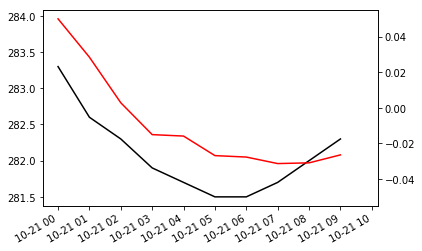

In [6]:
time_axes_precipitation = np.array(time_axes_precipitation)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_axes,surface_temperature,color='k',label='Surface temperature')
ax.plot(time_axes,air2m_temperature,color='r',label='2m temperature')
ax_r = ax.twinx()
ax_r.bar(time_axes_precipitation-datetime.timedelta(seconds=1800),precipitation_rate,width=0.1,alpha=0.4)
fig.autofmt_xdate()
plt.show()

We could improve this plot by extending the time axes. To do this, increase the `count` parameter in the API call.

Also note that only three contexts are needed for the data of interest. If we explicitly request those contexts and skip unnecessary ones, we can improve the API response time.

*__Note:__ Be careful with reference times, because in some cases two reference times may be available!*

In [7]:
API_url = "http://api.planetos.com/v1/datasets/noaa_gfs_global_sflux_0.12d/point?lon={0}&lat={1}&count=1000&verbose=true&apikey={2}&contexts=reftime_time_lat_lon,reftime_time_height_above_ground_lat_lon,reftime_time2_lat_lon,reftime_time1_lat_lon".format(longitude,latitude,apikey)
request2 = Request(API_url)
response2 = urlopen(request2)
API_data2 = json.loads(response2.read())

Let's find the available reference times in the response...

In [8]:
reftimes = set()
for i in API_data2['entries']:
    reftimes.update([i['axes']['reftime']])
reftimes=list(reftimes)

In [9]:
reftimes

['2019-10-21T00:00:00']

We use the earlier reftime in this example, but a later reftime may provide a more recent forecast.

In [10]:
if len(reftimes)>1:
    reftime = reftimes[0] if dateutil.parser.parse(reftimes[0])<dateutil.parser.parse(reftimes[1]) else reftimes[1]
else:
    reftime = reftimes[0]

Now create a new plot with the longer time scale and one more variable...

In [11]:
time_2mt = []
time_surft = []
time_precipitation = []
time_surfrad = []
surface_temperature = []
air2m_temperature = []
precipitation_rate = []
surfrad = []
for i in API_data2['entries']:
    #print(i['context'])
    if i['context'] == 'reftime_time_lat_lon' and i['axes']['reftime']==reftime:
        surface_temperature.append(i['data']['Temperature_surface']-273.15)
        time_surft.append(dateutil.parser.parse(i['axes']['time']))        
    if i['context'] == 'reftime_time_height_above_ground_lat_lon' and i['axes']['reftime']==reftime:
        if 'Temperature_height_above_ground' in i['data']:
            air2m_temperature.append(i['data']['Temperature_height_above_ground']-273.15)
            time_2mt.append(dateutil.parser.parse(i['axes']['time']))
    if i['context'] == 'reftime_time1_lat_lon' and i['axes']['reftime'] == reftime:
        if 'Downward_Short-Wave_Radiation_Flux_surface_3_Hour_Average' in i['data']:
            surfrad.append(i['data']['Downward_Short-Wave_Radiation_Flux_surface_3_Hour_Average'])
            time_surfrad.append(dateutil.parser.parse(i['axes']['time']))
            precipitation_rate.append(i['data']['Precipitation_rate_surface_3_Hour_Average']*3*3600)
            time_precipitation.append(dateutil.parser.parse(i['axes']['time']))

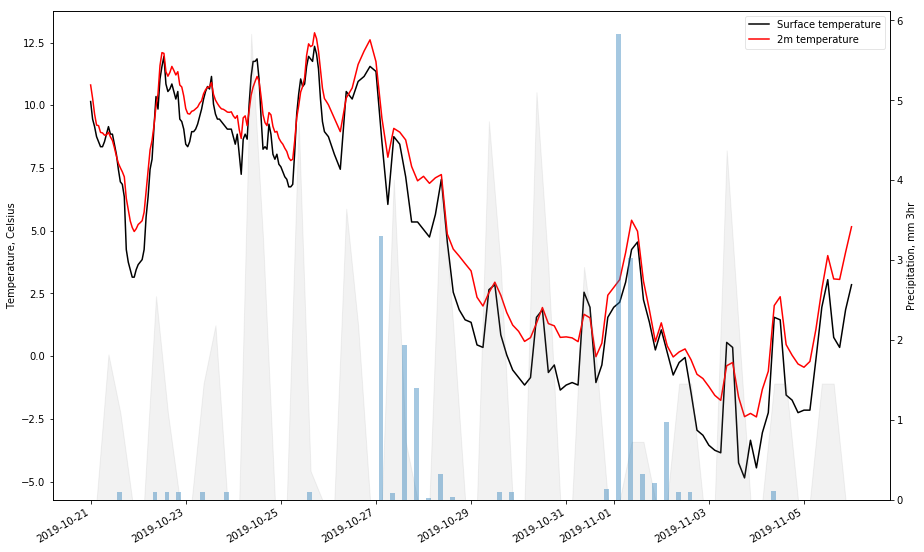

In [12]:
time_precipitation = np.array(time_precipitation)
surfrad=np.array(surfrad)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
plt.plot(time_surft,surface_temperature,color='k',label='Surface temperature')
plt.plot(time_2mt,air2m_temperature,color='r',label='2m temperature')
lg = plt.legend(framealpha=0.2)
ax.set_ylabel('Temperature, Celsius')

ax_r = ax.twinx()
ax_r.bar(time_precipitation-datetime.timedelta(seconds=1800),precipitation_rate,width=0.1,alpha=0.4,label='precipitation')
ax_r.fill_between(time_surfrad,surfrad/np.amax(surfrad)*np.amax(precipitation_rate),color='gray',alpha=0.1,label='surface radiation')
ax_r.set_ylabel('Precipitation, mm 3hr')
lg.get_frame().set_alpha(0.5)

fig.autofmt_xdate()